# Actividad 3
Redes neuronales para la clasificacion de imagenes

In [10]:
# Procesa cada una de las imágenes de tal manera que para cada imagen de color, se obtenga una imagen binaria de 32 x 32 donde el trazo principal del emoji esté centrado y ocupando el mayor espacio posible de la imagen.
 
import zipfile
import os
import cv2
import numpy as np
from PIL import Image
# Extraer imágenes del ZIP
with zipfile.ZipFile('Emojis.zip', 'r') as zip_ref:
    zip_ref.extractall('emojis_temp')

# Procesar cada imagen en cada carpeta de categoría
processed_images = []
labels = []

for category in os.listdir('emojis_temp'):
    category_path = os.path.join('emojis_temp', category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
                contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    cnt = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(cnt)
                    cropped = binary[y:y+h, x:x+w]
                    resized = cv2.resize(cropped, (28, 28), interpolation=cv2.INTER_NEAREST)
                    canvas = np.zeros((32, 32), dtype=np.uint8)
                    x_offset = (32 - resized.shape[1]) // 2
                    y_offset = (32 - resized.shape[0]) // 2
                    canvas[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized
                    processed_images.append(canvas)
                    labels.append(category) 

In [11]:
# importar librerias necesarias
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [12]:
X = np.array(processed_images).astype('float32') / 255.0
X = X.reshape(len(X), 32*32)  # aplanar imágenes

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_num = le.fit_transform(labels)
y = to_categorical(y_num)

# Divide en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2024, 1024)
Forma de y_train: (2024, 5)
Forma de X_test: (506, 1024)
Forma de y_test: (506, 5)


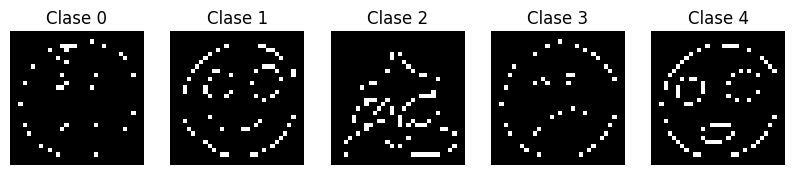

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(y.shape[1]):
    ax = axes[i]
    idx = np.where(y.argmax(axis=1) == i)[0]
    if len(idx) > 0:
        ax.imshow(X[idx[0]].reshape(32, 32), cmap='gray')
        ax.set_title(f'Clase {i}')
    else:
        ax.set_title(f'Clase {i}\n(sin datos)')
    ax.axis('off')

In [16]:
# Define la funcion que crea el modelo MLP con keras
def crear_modelo(input_dim, num_classes):
    modelo = Sequential()
   
    modelo.add(Dense(128, activation='relu', input_dim=input_dim))
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dense(num_classes, activation='softmax'))
   
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return modelo

In [18]:
# Entrena un modelo con los datos de entrenamiento
modelo = crear_modelo(input_dim=32*32, num_classes=y.shape[1])
modelo.summary()
modelo.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,781 (546.02 KB)

 Trainable params: 139,781 (546.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4531 - loss: 1.2858 - val_accuracy: 0.0020 - val_loss: 6.8753
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6734 - loss: 0.8862 - val_accuracy: 0.0000e+00 - val_loss: 8.2708
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7619 - loss: 0.6729 - val_accuracy: 0.0000e+00 - val_loss: 9.0486
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8221 - loss: 0.5093 - val_accuracy: 0.0000e+00 - val_loss: 9.5071
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8799 - loss: 0.3632 - val_accuracy: 0.0000e+00 - val_loss: 10.4170
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9254 - loss: 0.2572 - val_accuracy: 0.0000e+00 - val_loss: 11.5651
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9382 - loss: 0.2008 - val_accuracy: 0.0000e+00 - val_loss: 11.3598
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9521 - loss: 0.1466 - val

In [20]:
# Evalua el modelo con los datos de prueba
y_pred = modelo.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.68      0.96      0.80        99
           1       0.83      0.99      0.90        99
           2       0.89      0.99      0.94       110
           3       0.70      0.90      0.79        98
           4       0.00      0.00      0.00       100

    accuracy                           0.77       506
   macro avg       0.62      0.77      0.68       506
weighted avg       0.62      0.77      0.69       506



c:\Users\Dante\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dante\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dante\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [21]:
# Reformatear mis datos para una CNN
X_cnn = np.array(processed_images).astype('float32') / 255.0
X_cnn = X_cnn.reshape(-1, 32, 32, 1)

In [22]:
# Dividir mis datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [23]:
#Creo y entreno un modelo CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def crear_cnn(input_shape, num_classes):
    modelo = Sequential()
    modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Flatten())
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dense(num_classes, activation='softmax'))
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return modelo

modelo_cnn = crear_cnn(input_shape=(32, 32, 1), num_classes=y.shape[1])
modelo_cnn.summary()
modelo_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

c:\Users\Dante\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,509 (1.76 MB)

 Trainable params: 461,509 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4824 - loss: 1.2468 - val_accuracy: 0.5457 - val_loss: 1.1279
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6603 - loss: 0.8961 - val_accuracy: 0.5654 - val_loss: 1.0652
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7146 - loss: 0.7270 - val_accuracy: 0.5457 - val_loss: 1.0584
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7628 - loss: 0.6087 - val_accuracy: 0.5901 - val_loss: 1.0448
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8116 - loss: 0.5149 - val_accuracy: 0.5753 - val_loss: 1.0649
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8586 - loss: 0.4027 - val_accuracy: 0.5901 - val_loss: 1.0932
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9123 - loss: 0.3094 - val_accuracy: 0.6000 - val_loss: 1.1604
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9259 - loss: 0.2464 - val_accuracy: 0.5926 - v

In [24]:
# Evaluo mi modelo CNN
y_pred = modelo_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.54      0.47      0.51        99
           1       0.66      0.75      0.70        99
           2       0.94      0.93      0.94       110
           3       0.47      0.48      0.47        98
           4       0.57      0.56      0.57       100

    accuracy                           0.64       506
   macro avg       0.64      0.64      0.64       506
weighted avg       0.64      0.64      0.64       506

